# XGBoost Parameter Tuning for Otto Dataset

我们以Kaggle 2015年举办的Otto Group Product Classification Challenge竞赛数据为例，进行XGBoost参数调优探索。

竞赛官网：https://www.kaggle.com/c/otto-group-product-classification-challenge/data

# 第二步：调整树的参数：max_depth & min_child_weight
(粗调，参数的步长为2；下一步是在粗调最佳参数周围，将步长降为1，进行精细调整)

首先 import 必要的模块

In [8]:
from xgboost import XGBClassifier
import xgboost as xgb

import pandas as pd 
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import log_loss

from matplotlib import pyplot
import seaborn as sns
%matplotlib inline

## 读取数据

In [9]:
# path to where the data lies
dpath = '../data/'
train = pd.read_csv(dpath +"Otto_train.csv")
#train.head()

## Variable Identification

选择该数据集是因为的数据特征单一，我们可以在特征工程方面少做些工作，集中精力放在参数调优上

## Target 分布，看看各类样本分布是否均衡

In [10]:
#sns.countplot(train.target);
#pyplot.xlabel('target');
#pyplot.ylabel('Number of occurrences');

每类样本分布不是很均匀，所以交叉验证时也考虑各类样本按比例抽取

In [11]:
# drop ids and get labels
y_train = train['target']
y_train = y_train.map(lambda s: s[6:])
y_train = y_train.map(lambda s: int(s)-1)

train = train.drop(["id", "target"], axis=1)
X_train = np.array(train)

各类样本不均衡，交叉验证是采用StratifiedKFold，在每折采样时各类样本按比例采样

In [12]:
# prepare cross validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)

第一轮参数调整得到的n_estimators最优值（699），其余参数继续默认值

用交叉验证评价模型性能时，用scoring参数定义评价指标。评价指标是越高越好，因此用一些损失函数当评价指标时，需要再加负号，如neg_log_loss，neg_mean_squared_error 详见sklearn文档：http://scikit-learn.org/stable/modules/model_evaluation.html#log-loss

In [13]:
#max_depth 建议3-10， min_child_weight=1／sqrt(ratio_rare_event) =5.5
max_depth = [6,7,8]
min_child_weight = [4,5,6]
param_test2_2 = dict(max_depth=max_depth, min_child_weight=min_child_weight)
param_test2_2

{'max_depth': [6, 7, 8], 'min_child_weight': [4, 5, 6]}

In [14]:
xgb2_2 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=699,  #第一轮参数调整得到的n_estimators最优值
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.3,
        colsample_bytree=0.8,
        colsample_bylevel = 0.7,
        objective= 'multi:softprob',
        seed=3)


gsearch2_2 = GridSearchCV(xgb2_2, param_grid = param_test2_2, scoring='neg_log_loss',n_jobs=-1, cv=kfold)
gsearch2_2.fit(X_train , y_train)

gsearch2_2.best_params_,gsearch2_2.best_score_

({'max_depth': 6, 'min_child_weight': 4}, -0.47053407342942827)

In [15]:
gsearch2_2.cv_results_

/usr/local/python3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/python3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/python3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/python3/lib/python3.6/site-packa

{'mean_fit_time': array([1133.42426047, 1122.0469697 , 1117.89679346, 1302.23126731,
        1287.01319194, 1277.40086632, 1459.65140285, 1436.0263793 ,
        1260.26881433]),
 'std_fit_time': array([ 2.33487749,  6.35521586,  4.66521134,  4.38296898,  3.35964646,
         5.20857217,  8.71108317, 11.00314695,  2.97437702]),
 'mean_score_time': array([15.33151822, 14.68739858, 14.8433454 , 17.9570899 , 16.99020972,
        17.09509549, 20.83593664, 19.29796028, 15.31392303]),
 'std_score_time': array([0.49420885, 0.17010734, 0.78349853, 0.59560999, 0.49964717,
        0.80335342, 2.30805216, 3.21238394, 0.46339354]),
 'param_max_depth': masked_array(data=[6, 6, 6, 7, 7, 7, 8, 8, 8],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_min_child_weight': masked_array(data=[4, 5, 6, 4, 5, 6, 4, 5, 6],
              mask=[False, False, False, False, False, False, False, False,


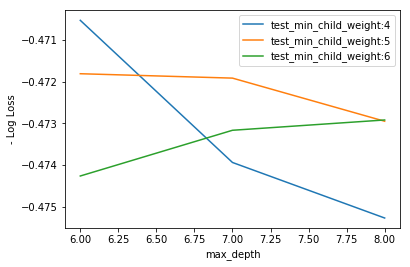

In [17]:
# summarize results
#print("Best: %f using %s" % (gsearch1.best_score_, gsearch1.best_params_))
test_means = gsearch2_2.cv_results_[ 'mean_test_score' ]
test_stds = gsearch2_2.cv_results_[ 'std_test_score' ]
train_means = gsearch2_2.cv_results_[ 'mean_train_score' ]
train_stds = gsearch2_2.cv_results_[ 'std_train_score' ]

pd.DataFrame(gsearch2_2.cv_results_).to_csv('my_preds_maxdepth_min_child_weights_2.csv')

# plot results
test_scores = np.array(test_means).reshape(len(min_child_weight), len(max_depth))
train_scores = np.array(train_means).reshape(len(min_child_weight), len(max_depth))

for i, value in enumerate(min_child_weight):
    pyplot.plot(max_depth, test_scores[i], label= 'test_min_child_weight:'   + str(value))
#for i, value in enumerate(min_child_weight):
#    pyplot.plot(max_depth, train_scores[i], label= 'train_min_child_weight:'   + str(value))
    
pyplot.legend()
pyplot.xlabel( 'max_depth' )                                                                                                      
pyplot.ylabel( '- Log Loss' )
pyplot.savefig( 'max_depth_vs_min_child_weght2.png' )